# Generalization Dataset 3

### NOTE: This notebook was originally ran using python 3.11.3

# GET EVERYTHING READY

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import ticker
import matplotlib.patches as mpatches
from scipy.stats import pearsonr, spearmanr
from scipy.optimize import curve_fit
import glob

# R stuff:
%load_ext rpy2.ipython

# Settings
sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=1.8, rc={"lines.linewidth": 2.5,"lines.markersize": 8})

# FITTING FUNCTION
# --------------------------------------------------------
def exponential_decay(x, asymp_to, improvement, alpha):
    return asymp_to + improvement * np.exp(-alpha * x)


# Read and parse data

In [4]:
# Load RT data function:
def load_RT_data():
    """Load and concatenate all RT data by site"""
    # Get all site files
    site_files = glob.glob('DATABASES/by_site/RT_*.csv')
    
    # Read and concatenate
    dfs = []
    for file in sorted(site_files):
        df = pd.read_csv(file)
        dfs.append(df)
    
    IPI_df = pd.concat(dfs, ignore_index=True)
    # print(f'Loaded {len(IPI_df)} rows from {len(site_files)} sites')
    
    return IPI_df

In [5]:
# Load data from CSV
IPI_df = load_RT_data()
Dependent_var_df_SCORE = pd.read_csv('DATABASES/DV_ALL_SITES.csv')

# complete the IPI dataframe:
# --------------------------------------------------------
IPI_df.rename(columns={'newID': 'subID'}, inplace=True)
IPI_df['IPI'] = IPI_df.groupby(['subID', 'trial'])['RT'].diff()
IPI_df['IPI_abs_diff'] = IPI_df['IPI'].diff().abs()
# merge with DV
Dependent_var_df_SCORE.rename(columns={'newID': 'subID', 'CHANGE_SCORE': 'behav_adaptation_SCORE'}, inplace=True)
# Normalize (standardize) behav_adaptation_SCORE in Dependent_var_df_SCORE PER SITE:
Dependent_var_df_SCORE['behav_adaptation_SCORE_NORMED'] = Dependent_var_df_SCORE.groupby('site')['behav_adaptation_SCORE'].transform(
    lambda x: (x - x.mean()) / x.std()
)
# if not already merged:
if 'behav_adaptation_SCORE' not in IPI_df.columns: IPI_df = IPI_df.merge(Dependent_var_df_SCORE[['subID', 'behav_adaptation_SCORE', 'behav_adaptation_SCORE_NORMED']], on='subID', how='left')
main_data_df = IPI_df.copy()

# Create block-level data:
# --------------------------------------------------------
agg_dict = {
    'IPI': ['mean'],
    'IPI_abs_diff': 'mean',
    'press_freq': 'first',
    'first_RT': 'first',
}

# create a column of one raw per sub per trial:
trial_level_df = main_data_df.groupby(['subID','group', 'trial', 'day', 'run', 'outcome', 'behav_adaptation_SCORE_NORMED']).agg(agg_dict).reset_index()
flattened_columns = []
for col in trial_level_df.columns:
    if isinstance(col, tuple):
        var_name, agg_name = col
        # Check if the variable had multiple aggregations
        if isinstance(agg_dict.get(var_name), list) and len(agg_dict[var_name]) > 1:
            flattened_columns.append(f"{var_name}_{agg_name}")
        else:
            flattened_columns.append(var_name)
    else:
        flattened_columns.append(col)
trial_level_df.columns = flattened_columns

trial_level_df.rename(columns={'press_freq': 'resp_rate'}, inplace=True)
# recreate trial such that there are no missing trials (if there is 1 and 3 the 3 will switch to 2 and the next one to three etc.):
trial_level_df['trial_orig'] = trial_level_df['trial']
trial_level_df['trial'] = trial_level_df.groupby(['subID']).cumcount() + 1


# ----- IPI Consistency (Automaticity) -----

## Analysis - modeling

In [6]:
IPI_consistency_data_by_trial = main_data_df.copy()
IPI_consistency_data_by_trial.rename(columns={'outcome': 'stim_condition', 'subID': 'sub'}, inplace=True)
# convert to ms:
IPI_consistency_data_by_trial['IPI_abs_diff'] = IPI_consistency_data_by_trial['IPI_abs_diff'] * 1000


### Modeling

In [7]:
var = 'IPI_abs_diff'
var_of_comparison = 'stim_condition' 
to_smooth = True
smoothing_window = 5
min_period = None

sns.set_context("paper", font_scale=1.6, rc={
    "lines.linewidth": 2.5,
    "lines.markersize": 8
})

# fit the exponential decay to the data:
# -------------------------------------------
# prepare the data:
relevant_trial_data = IPI_consistency_data_by_trial.copy()
if var_of_comparison:
    grouping_factos = ['sub', 'stim_condition']
    stim_condition = var_of_comparison
else:
    grouping_factos = ['sub']
    stim_condition = 'all_stimuli'

relevant_trial_data.loc[:, 'stim_abs_trial'] = relevant_trial_data.groupby(grouping_factos).cumcount()

# remove nans:
relevant_trial_data = relevant_trial_data[relevant_trial_data[var].notna()]

results_df = pd.DataFrame()

# run the fitting procedure:
for sub in relevant_trial_data['sub'].unique():
    # prepare sub data:
    # ------------------------
    data = relevant_trial_data[relevant_trial_data['sub'] == sub]
    data = data.copy()
    data.loc[:, 'smoothed_data'] = data.groupby('stim_condition')[var].transform(lambda x: x.rolling(window=smoothing_window, min_periods=min_period).mean())
    # remove nans:
    data = data[data['smoothed_data'].notna()].reset_index(drop=True)
    # re-create the stim_abs_trial:
    data.loc[:, 'stim_abs_trial'] = data.groupby(grouping_factos).cumcount()
    
    # Average across conditions at each trial
    avg_data = data.groupby('stim_abs_trial')['smoothed_data'].mean().reset_index()

    x_data = avg_data['stim_abs_trial']
    y_data_smoothed = avg_data['smoothed_data']

    # fit the exponential decay:
    # --------------------------
    # Calculate initial guesses from the data:
    y_start = y_data_smoothed.iloc[0]
    y_end = y_data_smoothed.iloc[-1]
    improvement_guess = abs(y_start - y_end)
    asymp_guess = y_end
    p0 = (asymp_guess, improvement_guess, 0.01)

    popt, pcov = curve_fit(exponential_decay, x_data, y_data_smoothed, p0=p0, maxfev=100000, bounds=([0, 0, 0], [35000, 35000, 10000]))
    y_predicted = exponential_decay(x_data, *popt)

    # Calculate the residuals, sum of squares of residuals and the total sum of squares
    residuals = y_data_smoothed - y_predicted
    ss_residuals = np.sum(residuals**2)
    ss_total = np.sum((y_data_smoothed - np.mean(y_data_smoothed))**2)
    # calculate the R squared:
    r_squared = 1 - (ss_residuals / ss_total)

    # relative gain of performance ('improvement') by the final point (according to the model):
    end_of_training_pred = exponential_decay(x_data.max(), *popt)
    relative_improvement_accomplished = 1 - ((end_of_training_pred - popt[0]) / popt[1])

    results_df = pd.concat([results_df, pd.DataFrame({'sub': sub, 'group': data['group'].iloc[0], 'stim_condition': stim_condition, 'asymp_to': popt[0], 'improvement': popt[1], 'alpha': popt[2], 'end_of_training_pred': end_of_training_pred, 'relative_improvement_accomplished': relative_improvement_accomplished, 'r_squared': r_squared}, index=[0])])
    
results_df = results_df.reset_index(drop=True)
print(f'mean R^2: {results_df.r_squared.mean().round(3)}')

mean R^2: 0.042


In [8]:
# add the data to the main data:
# -------------------------------------------
Dependent_vars_copy = IPI_df[['subID', 'behav_adaptation_SCORE_NORMED']].drop_duplicates()
Dependent_vars_copy.rename(columns={'subID': 'sub'}, inplace=True)
main_data_df_w_fitting = pd.merge(Dependent_vars_copy, results_df.drop(columns=['stim_condition']), on=['sub'], how='left')

### Fig 4B + stats

Pearson correlation for end_of_training_pred with devaluation ratio: 0.114, p-value: 0.0236
Degrees of freedom for Pearson correlation: 304
Spearman correlation for end_of_training_pred with devaluation ratio: 0.114, p-value: 0.0232


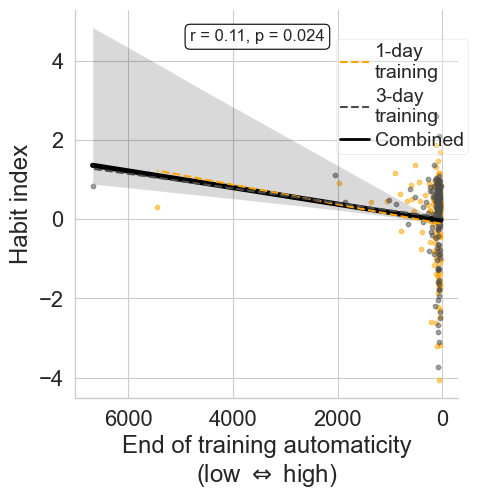

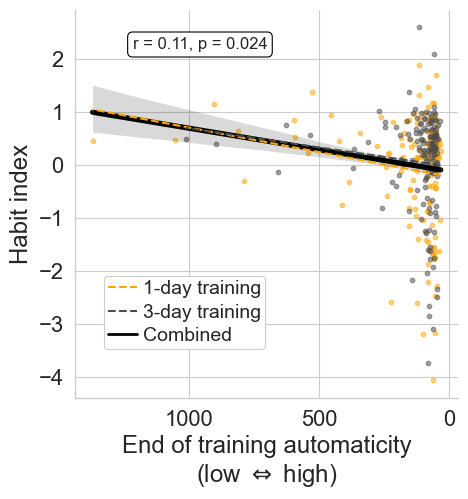

Removed 5 data points for visualization purposes


In [9]:
only_after_devalued_data = main_data_df_w_fitting.copy()
only_after_devalued_data['habit_level'] = -1 * only_after_devalued_data['behav_adaptation_SCORE_NORMED']

# Pearson correlation (and Spearman to verify robustness using non-parametric correlation):
pearson_corr, pearson_p = pearsonr(only_after_devalued_data['end_of_training_pred'], only_after_devalued_data['habit_level'], alternative='greater')
print(f"Pearson correlation for end_of_training_pred with devaluation ratio: {pearson_corr:.3f}, p-value: {pearson_p:.4f}")
print(f"Degrees of freedom for Pearson correlation: {len(only_after_devalued_data['end_of_training_pred']) - 2}")
spearman_corr, spearman_p = spearmanr(only_after_devalued_data['end_of_training_pred'], only_after_devalued_data['habit_level'], alternative='greater')
print(f"Spearman correlation for end_of_training_pred with devaluation ratio: {spearman_corr:.3f}, p-value: {spearman_p:.4f}")

sns.set_context("paper", font_scale=1.8, rc={
    "lines.linewidth": 2.5,
    "lines.markersize": 8
})

pallette = ['orange', (0.3, 0.3, 0.3)]

g = sns.lmplot(
    data=only_after_devalued_data,
    x='end_of_training_pred', y='habit_level',
    hue='group', hue_order=['1-day', '3-day'],
    palette=pallette,
    order=1,
    scatter_kws={'s': 10, 'alpha': 0.5},
    line_kws={'linestyle': '--', 'linewidth': 1.5},
    ci=None,
    height=5, aspect=1,
    legend=False
)

sns.regplot(
    data=only_after_devalued_data,
    x='end_of_training_pred', y='habit_level',
    scatter=False, line_kws={'color': 'black', 'zorder': 1},
    order=1,
    ax=g.ax
)

plt.ylabel('Habit index')
plt.xlabel('End of training automaticity\n(low $\Leftrightarrow$ high)')

custom_lines = [
    Line2D([0], [0], color=pallette[0], linestyle='--', linewidth=1.5,
           label='1-day\ntraining'),
    Line2D([0], [0], color=pallette[1], linestyle='--', linewidth=1.5,
           label='3-day\ntraining'),
    Line2D([0], [0], color='black', linestyle='-', linewidth=2,
           label='Combined')
]

legend = plt.legend(
    handles=custom_lines,
    title=None,
    loc='upper right',
    bbox_to_anchor=(1.05, 0.95),
    fontsize=14,
    frameon=True,
    framealpha=0.3,
    labelspacing=0.3,
    handletextpad=0.3,
    borderpad=0.2,
    handlelength=1.5
)
plt.annotate(f"r = {pearson_corr:.2f}, p = {pearson_p:.3f}", xy=(0.3, 0.95), xycoords="axes fraction", fontsize=12, ha="left", va="top", bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black"))
plt.gca().invert_xaxis()
plt.show()

# NOTE: now without outliers for visualization purposes:
# ---------------------------------------------------------
g = sns.lmplot(
    data=only_after_devalued_data[only_after_devalued_data.end_of_training_pred<1500],
    x='end_of_training_pred', y='habit_level',
    hue='group', hue_order=['1-day', '3-day'],
    palette=pallette,
    order=1,
    scatter_kws={'s': 10, 'alpha': 0.5},
    line_kws={'linestyle': '--', 'linewidth': 1.5},
    ci=None,
    height=5, aspect=1,
    legend=False
)

sns.regplot(
    data=only_after_devalued_data[only_after_devalued_data.end_of_training_pred<1500],
    x='end_of_training_pred', y='habit_level',
    scatter=False, line_kws={'color': 'black', 'zorder': 1},
    order=1,
    ax=g.ax
)

plt.ylabel('Habit index')
plt.xlabel('End of training automaticity\n(low $\Leftrightarrow$ high)')
custom_lines = [
    Line2D([0], [0], color=pallette[0], linestyle='--', linewidth=1.5,
           label='1-day training'),
    Line2D([0], [0], color=pallette[1], linestyle='--', linewidth=1.5,
           label='3-day training'),
    Line2D([0], [0], color='black', linestyle='-', linewidth=2,
           label='Combined')
]

legend = plt.legend(
    handles=custom_lines,
    title=None,
    loc='upper right',
    bbox_to_anchor=(0.52, 0.34),
    fontsize=14,
    frameon=True,
    framealpha=1,
    labelspacing=0.3,
    handletextpad=0.3,
    borderpad=0.2,
    handlelength=1.5
)
plt.annotate(f"r = {pearson_corr:.2f}, p = {pearson_p:.3f}", xy=(0.15, 0.93), xycoords="axes fraction", fontsize=12, ha="left", va="top", bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black"))
plt.gca().invert_xaxis()

plt.show()

print(f"Removed {only_after_devalued_data.shape[0] - only_after_devalued_data[only_after_devalued_data.end_of_training_pred<1500].shape[0]} data points for visualization purposes")



### Fig. S4 (rank plot)

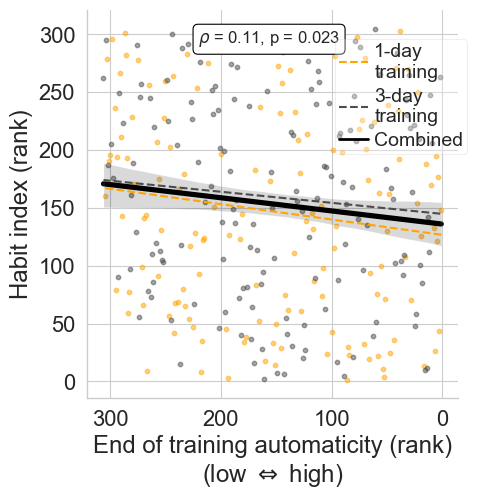

In [10]:
df = only_after_devalued_data.copy()
df['x_rank'] = df['end_of_training_pred'].rank(method='average')
df['y_rank'] = df['habit_level'].rank(method='average')

g = sns.lmplot(
    data=df,
    x='x_rank', y='y_rank',
    hue='group', hue_order=['1-day', '3-day'],
    palette=pallette,
    order=1,
    scatter_kws={'s': 10, 'alpha': 0.5},
    line_kws={'linestyle': '--', 'linewidth': 1.5},
    ci=None,
    height=5, aspect=1,
    legend=False
)

sns.regplot(
    data=df,
    x='x_rank', y='y_rank',
    scatter=False,
    line_kws={'color': 'black', 'zorder': 1},
    order=1,
    ax=g.ax
)

plt.ylabel('Habit index (rank)')
plt.xlabel('End of training automaticity (rank)\n(low $\\Leftrightarrow$ high)')
custom_lines = [
    Line2D([0], [0], color=pallette[0], linestyle='--', linewidth=1.5, label='1-day\ntraining'),
    Line2D([0], [0], color=pallette[1], linestyle='--', linewidth=1.5, label='3-day\ntraining'),
    Line2D([0], [0], color='black', linestyle='-', linewidth=2, label='Combined')
]
plt.legend(
    handles=custom_lines,
    title=None,
    loc='upper right',
    bbox_to_anchor=(1.05, 0.95),
    fontsize=14,
    frameon=True,
    framealpha=0.3,
    labelspacing=0.3,
    handletextpad=0.3,
    borderpad=0.2,
    handlelength=1.5
)

plt.annotate(
    f"$\\rho$ = {spearman_corr:.2f}, p = {spearman_p:.3f}",
    xy=(0.3, 0.95), xycoords="axes fraction",
    fontsize=12, ha="left", va="top",
    bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black")
)

plt.gca().invert_xaxis()
plt.show()


## --- TERTILES of habit expression

In [11]:
# checking the proportion of participants with perfect goal-directed behavior (0 habits)
Dependent_var_df_SCORE['post_deval'].min()
Dependent_var_df_SCORE['post_deval'].shape
Dependent_var_df_SCORE[(Dependent_var_df_SCORE['post_deval']==0) & (Dependent_var_df_SCORE['post_val']>0)].shape # 25 subjects
25/306

0.08169934640522876

### End of training automaticity across the tertiles

#### Fig 4C

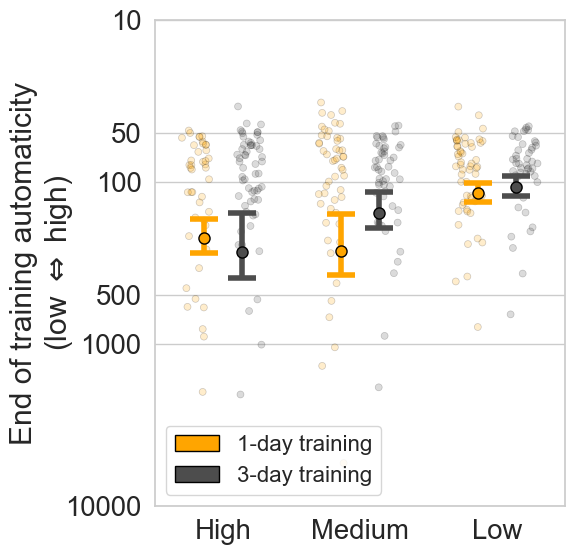

In [12]:
# ---------- style ----------
sns.set(font_scale=1.8)
sns.set_style("whitegrid")

# add tertile:
only_after_devalued_data['tertile'] = pd.qcut(only_after_devalued_data['behav_adaptation_SCORE_NORMED'], 3, labels=["T1", "T2", "T3"])
only_after_devalued_data['tertile'] = (only_after_devalued_data['tertile'].cat.rename_categories({"T1": "High", "T2": "Medium", "T3": "Low"}))

# ---------- ordering & palette ----------
habit_order = ["High", "Medium", "Low"]
hue_order   = ["1-day", "3-day"]
pallette = ['orange', (0.3, 0.3, 0.3)]
colors = {'1-day': pallette[0], '3-day': pallette[1]}
new_labels = ['1-day training', '3-day training']

# ---------- summary stats (means & SE) ----------
stats = (
    only_after_devalued_data
    .groupby(['tertile', 'group'], observed=True)['end_of_training_pred']
    .agg(mean='mean', se='sem')
    .reindex(pd.MultiIndex.from_product([habit_order, hue_order],
                                        names=['tertile','group']))
)

# pull arrays in the right order for plotting
means = {g: stats.xs(g, level='group')['mean'].values for g in hue_order}
ses   = {g: stats.xs(g, level='group')['se'  ].values for g in hue_order}

# ---------- plot ----------
fig, ax = plt.subplots(figsize=(6.2, 6))

x = np.arange(len(habit_order))
width = 0.28                        
offsets = [-width/2, width/2]

for i, g in enumerate(hue_order):
    ax.errorbar(
        x=x + offsets[i],
        y=means[g],
        yerr=ses[g],
        fmt='o',
        markersize=8,
        linewidth=4,          
        capsize=10,
        capthick=4,   
        color=colors[g],    
        markerfacecolor=colors[g],
        markeredgecolor='black',
        zorder=3
    )

ax.set_xticks(x)
ax.set_xticklabels(habit_order)

# Plot individual points
sns.stripplot(
    data=only_after_devalued_data,
    x="tertile",
    y="end_of_training_pred",
    hue="group",
    order=habit_order,
    hue_order=hue_order,
    palette=colors,
    dodge=True,
    jitter=0.2,
    alpha=0.2,
    edgecolor='black',
    linewidth=0.5,
    ax=ax,
    zorder=2
)

# log scale:
plt.yscale('log')
ax.set_yticks([10, 50, 100, 500, 1000, 10000])
ax.get_yaxis().set_major_formatter(ticker.ScalarFormatter())
ax.set_ylabel('End of training automaticity\n(low $\\Leftrightarrow$ high)', labelpad=-7)
ax.set_xlabel("")
ax.invert_yaxis()
plt.ylim(top=10)

patches = [mpatches.Patch(facecolor=colors[g], edgecolor='black', label=lbl)
           for g, lbl in zip(hue_order, new_labels)]
leg = ax.legend(handles=patches, fontsize=16, frameon=True, loc='lower left')

plt.tight_layout()
plt.show()


#### stats

In [13]:
%%R -i only_after_devalued_data
library(car)
library(lmtest)    
library(sandwich)
library(emmeans)
# Ensure factor coding
only_after_devalued_data$tertile <- factor(only_after_devalued_data$tertile,levels = c("Low", "Medium", "High"))
only_after_devalued_data$group <- factor(only_after_devalued_data$group,levels = c("1-day", "3-day"))
# effect coding:
contrasts(only_after_devalued_data$tertile) <- contr.sum(3)
contrasts(only_after_devalued_data$group) <- contr.sum(2)

model <- lm(end_of_training_pred ~ tertile*group, data = only_after_devalued_data)
print(summary(model))
print(ncvTest(model))   # Non-constant variance score test
print(Anova(model, type = "III", white.adjust = TRUE))

print('>>>>> Corrected SEs for between level comparison <<<<<')
Vsum  <- vcovHC(model, type = "HC3")
emm_t2 <- emmeans(model, ~ tertile, vcov. = Vsum, weights = "equal")
print(pairs(emm_t2, adjust = "none"))
print('>>>>>>>>>>>><<<<<<<<<<<')


Call:
lm(formula = end_of_training_pred ~ tertile * group, data = only_after_devalued_data)

Residuals:
   Min     1Q Median     3Q    Max 
-238.8 -163.6  -68.3  -25.4 6412.5 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)      190.463     31.016   6.141  2.6e-09 ***
tertile1         -78.309     43.817  -1.787   0.0749 .  
tertile2          20.933     43.749   0.478   0.6327    
group1            12.149     31.016   0.392   0.6955    
tertile1:group1   -7.007     43.817  -0.160   0.8731    
tertile2:group1   44.358     43.749   1.014   0.3114    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 539.7 on 300 degrees of freedom
Multiple R-squared:  0.01619,	Adjusted R-squared:  -0.0002055 
F-statistic: 0.9875 on 5 and 300 DF,  p-value: 0.4255

Non-constant Variance Score Test 
Variance formula: ~ fitted.values 
Chisquare = 155.2294, Df = 1, p = < 2.22e-16
Analysis of Deviance Table (Type III tests)

Respons

Loading required package: carData
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Coefficient covariances computed by hccm()
NOTE: Results may be misleading due to involvement in interactions
In addition: Warning messages:
1: package ‘car’ was built under R version 4.3.3 
2: package ‘lmtest’ was built under R version 4.3.3 
3: package ‘sandwich’ was built under R version 4.3.3 


### Trajectories of the tertiles

#### Fig 4D

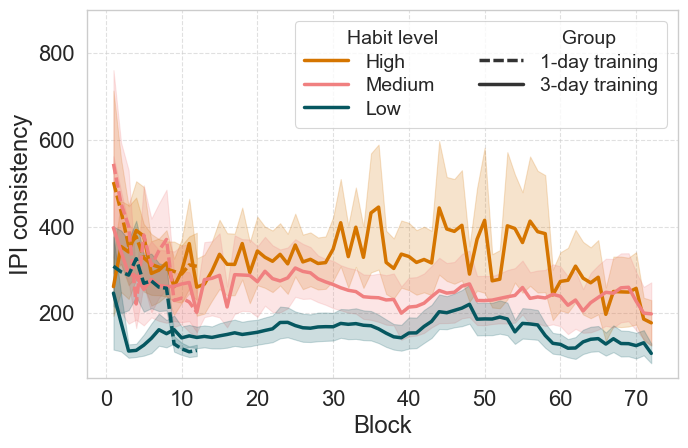

In [14]:
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.8, rc={
    "lines.linewidth": 2.5,
    "lines.markersize": 8
})
palette=["#D57500", "lightcoral", "#065760"]
palette_mapping = {
    'Low': palette[0],
    'Medium': palette[1],
    'High': palette[2]
}
fig_size_factor = 0.8
fig_size = (9*fig_size_factor, 6*fig_size_factor)

# --- Data prep ---
IPI_consistency_data_by_trial_isHabitual = IPI_consistency_data_by_trial.merge(
    only_after_devalued_data[['sub', 'tertile']],
    on='sub',
    how='left'
)

IPI_consistency_data_by_trial_isHabitual_byBlock = IPI_consistency_data_by_trial_isHabitual.groupby(['sub', 'group', 'trial', 'tertile', 'stim_condition'], observed=True).agg({'IPI_abs_diff': 'mean'}).reset_index()
IPI_consistency_data_by_trial_isHabitual_byBlock['stim_abs_trial'] = IPI_consistency_data_by_trial_isHabitual_byBlock.groupby(['sub', 'stim_condition'], observed=True).cumcount() + 1


measure_mean = IPI_consistency_data_by_trial_isHabitual_byBlock.IPI_abs_diff.mean()
measure_std = IPI_consistency_data_by_trial_isHabitual_byBlock.IPI_abs_diff.std()
# remove outlies with more than 10 SD from the mean (for visualization purposes):
IPI_consistency_data_by_trial_isHabitual_byBlock = IPI_consistency_data_by_trial_isHabitual_byBlock[
    (IPI_consistency_data_by_trial_isHabitual_byBlock['IPI_abs_diff'] < measure_mean + 10 * measure_std) &
    (IPI_consistency_data_by_trial_isHabitual_byBlock['IPI_abs_diff'] > measure_mean - 10 * measure_std)
].reset_index(drop=True)

custom_labels = {
    'Low': 'Low',
    'Medium': 'Medium',
    'High': 'High',
    '1-day': '1-day training',
    '3-day': '3-day training',
}

# Smoothing the IPI_abs_diff_sum by a rolling mean of 15 trials
IPI_consistency_data_by_trial_isHabitual_byBlock['smoothed_IPI_abs_diff'] = IPI_consistency_data_by_trial_isHabitual_byBlock.groupby(['sub', 'group', 'tertile', 'stim_condition'], observed=True)['IPI_abs_diff'].transform(lambda x: x.rolling(window=15, min_periods=1).mean())
IPI_consistency_data_by_trial_isHabitual_byBlock = IPI_consistency_data_by_trial_isHabitual_byBlock.groupby(['sub', 'group', 'tertile', 'stim_abs_trial'], observed=True).agg({'smoothed_IPI_abs_diff': 'mean'}).reset_index()

fig, axe = plt.subplots(1, 1, figsize=fig_size)
sns.lineplot(
    data=IPI_consistency_data_by_trial_isHabitual_byBlock,
    x='stim_abs_trial',
    y='smoothed_IPI_abs_diff',
    hue='tertile',
    style='group',
    palette=palette,
    legend='full',
    errorbar=('se', 1),
    dashes={'1-day': (3, 1), '3-day': (None, None)},
    ax=axe
)
axe.set_xlabel('Block')
axe.set_ylabel('IPI consistency')
# Remove Seaborn's automatic legend that includes titles
if axe.legend_:
    axe.legend_.remove()

# Get all handles and labels from the current plot
handles, labels = axe.get_legend_handles_labels()

# Match labels with custom ones, ignore empty or redundant ones
unique = []
used = set()
for h, l in zip(handles, labels):
    if l not in used and l in custom_labels:
        unique.append((h, custom_labels[l]))
        used.add(l)

# Add clean legend without a title
if unique:
    handles_clean, labels_clean = zip(*unique)
    legend = axe.legend(
        handles_clean,
        labels_clean,
        loc='upper right',
        ncol=2,           
        title='Habit level                       Group',
        labelspacing=0.2
    )
    for text in legend.texts:
        text.set_fontsize(14)
    legend.get_title().set_fontsize(14)
axe.grid(True, linestyle='--', alpha=0.6)
plt.ylim(top=900)      
plt.tight_layout()
plt.show()

#### stats

In [15]:
# get mean IPI_abs_diff per sub:
IPI_consistency_per_block = IPI_consistency_data_by_trial_isHabitual.groupby(['sub', 'group', 'trial', 'tertile'], observed=True)['IPI_abs_diff'].mean().reset_index()
IPI_consistency_per_block
IPI_consistency_per_block['tertile'].value_counts()

# Aggregate by block
IPI_consistency_per_block = IPI_consistency_data_by_trial_isHabitual.groupby(['sub', 'group', 'trial', 'tertile', 'stim_condition'], observed=True).agg({'IPI_abs_diff': 'mean'}).reset_index()
IPI_consistency_per_block['stim_abs_trial'] = IPI_consistency_per_block.groupby(['sub', 'group', 'stim_condition'], observed=True).cumcount() + 1
IPI_consistency_per_block = IPI_consistency_per_block.groupby(['sub', 'group', 'tertile', 'stim_abs_trial'], observed=True).agg({'IPI_abs_diff': 'mean'}).reset_index()

[1] "============================== MODEL SUMMARY [effect coding] =============================="
Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: IPI_abs_diff ~ stim_abs_trial * tertile * group + (1 | sub)
   Data: IPI_consistency_per_block

REML criterion at convergence: 200036.9

Scaled residuals: 
   Min     1Q Median     3Q    Max 
-9.078 -0.087 -0.022  0.008 33.751 

Random effects:
 Groups   Name        Variance Std.Dev.
 sub      (Intercept)  698585   835.8  
 Residual             1039354  1019.5  
Number of obs: 11937, groups:  sub, 306

Fixed effects:
                               Estimate Std. Error       df t value Pr(>|t|)  
(Intercept)                      194.64     106.09  4355.13   1.835   0.0666 .
stim_abs_trial                  -149.31      81.15 11761.14  -1.840   0.0658 .
tertile1                         -57.00     149.02  4273.31  -0.383   0.7021  
tertile2                         -29.42     147.46  4201.26  -0.200   

NOTE: Results may be misleading due to involvement in interactions
NOTE: Results may be misleading due to involvement in interactions
NOTE: Results may be misleading due to involvement in interactions
NOTE: Results may be misleading due to involvement in interactions
NOTE: Results may be misleading due to involvement in interactions


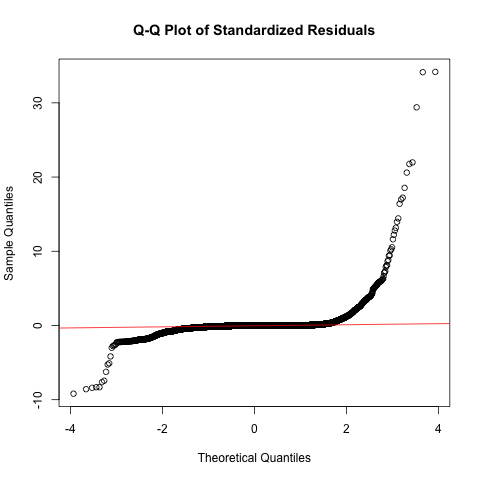

In [17]:
%%R -i IPI_consistency_per_block
library(car)
library(lme4)
library(lmerTest)
library(robustlmm)
library(clubSandwich)
library(emmeans)
library(lmtest)

# Prepare data
IPI_consistency_per_block$tertile <- factor(IPI_consistency_per_block$tertile, levels = c("Low","Medium","High"), ordered = FALSE)
IPI_consistency_per_block$group <- factor(IPI_consistency_per_block$group, levels = c("3-day","1-day"), ordered = FALSE)
IPI_consistency_per_block <- IPI_consistency_per_block[!is.na(IPI_consistency_per_block$IPI_abs_diff), ]
IPI_consistency_per_block$stim_abs_trial <- scale(IPI_consistency_per_block$stim_abs_trial)

print("============================== MODEL SUMMARY [effect coding] ==============================")
# Set effect coding
contrasts(IPI_consistency_per_block$tertile) <- contr.sum(3)
contrasts(IPI_consistency_per_block$group) <- contr.sum(2)
model_reg <- lmer(IPI_abs_diff ~ stim_abs_trial*tertile*group + (1|sub), data = IPI_consistency_per_block)
print(summary(model_reg))

# Heteroskedasticity checks
print("============================== HETEROSKEDASTICITY TESTS ==============================")
resid_data <- data.frame(sq_resid = residuals(model_reg)^2, fitted = fitted(model_reg))
bp_model <- lm(sq_resid ~ fitted, data = resid_data)
print("Breusch-Pagan test:")
print(summary(bp_model))

print("============================== Outliers TEST ==============================")
# Extract standardized residuals
std_resid <- residuals(model_reg) / sd(residuals(model_reg))

# Count extreme outliers (beyond ±3 SD)
n_outliers <- sum(abs(std_resid) > 3)
pct_outliers <- 100 * n_outliers / length(std_resid)

print(paste("Extreme outliers (>3 SD):", n_outliers, 
            "(", round(pct_outliers, 1), "%)"))

# Quick Q-Q plot
qqnorm(std_resid, main = "Q-Q Plot of Standardized Residuals")
qqline(std_resid, col = "red")

# Robustlmm analysis
print("============================== ROBUST MODEL (rlmer): Model summary ==============================")
model_robust <- rlmer(IPI_abs_diff ~ stim_abs_trial*tertile*group + (1|sub), data = IPI_consistency_per_block)
print(summary(model_robust))

print("============================== Coefficient names: ==============================")
print(names(fixef(model_robust)))

print("============================== Main effect of tertile: ==============================")
print(joint_tests(emmeans(model_robust, ~ tertile)))

print("============================== Main effect of group: ==============================")
print(joint_tests(emmeans(model_robust, ~ group)))

print("============================== Main effect of stim_abs_trial: ==============================")
print(test(emtrends(model_robust, ~ 1, var = "stim_abs_trial")))

print("============================== Tertile x Trial interaction: ==============================")
print(joint_tests(emtrends(model_robust, ~ tertile, var = "stim_abs_trial")))

print("============================== Group x Trial interaction: ==============================")
print(joint_tests(emtrends(model_robust, ~ group, var = "stim_abs_trial")))

print("============================== Tertile x Group interaction: ==============================")
print(joint_tests(emmeans(model_robust, ~ tertile * group)))

print("============================== 3-way interaction: ==============================")
print(joint_tests(emtrends(model_robust, ~ tertile * group, var = "stim_abs_trial")))


# ----- Response rate -----

## Modeling

In [18]:
IPI_consistency_data_by_trial

,oldSubID,sub,group,site,day,block,run,first_RT,press_freq,trial,stim_condition,RT,IPI,IPI_abs_diff,behav_adaptation_SCORE,behav_adaptation_SCORE_NORMED
0,1,51,1-day,Caltech1,1,1,1,1.349336,4.590496,1,devalued,1.349255,NaN,NaN,0.473206,-0.088625
1,1,51,1-day,Caltech1,1,1,1,1.349336,4.590496,1,devalued,1.535908,0.186653,NaN,0.473206,-0.088625
2,1,51,1-day,Caltech1,1,1,1,1.349336,4.590496,1,devalued,1.709187,0.173279,13.373386,0.473206,-0.088625
3,1,51,1-day,Caltech1,1,1,1,1.349336,4.590496,1,devalued,1.855940,0.146753,26.526384,0.473206,-0.088625
4,1,51,1-day,Caltech1,1,1,1,1.349336,4.590496,1,devalued,2.002576,0.146635,0.117733,0.473206,-0.088625
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2264318,241,368,3-day,Tel_Aviv,3,1,4,0.557987,0.401399,221,devalued,1.007383,0.150238,0.285869,1.977615,0.972763
2264319,241,368,3-day,Tel_Aviv,3,1,4,0.557987,0.401399,221,devalued,1.174591,0.167208,16.970518,1.977615,0.972763
2264320,241,368,3-day,Tel_Aviv,3,1,4,0.557987,0.401399,221,devalued,1.324235,0.149644,17.563773,1.977615,0.972763
2264321,241,368,3-day,Tel_Aviv,3,1,4,0.557987,0.401399,221,devalued,1.475371,0.151135,1.490645,1.977615,0.972763


In [19]:
IPI_consistency_data_by_trial = trial_level_df.copy()
IPI_consistency_data_by_trial.rename(columns={'outcome': 'stim_condition', 'subID': 'sub'}, inplace=True)


In [20]:
var = 'resp_rate'
var_of_comparison = 'stim_condition' 
to_smooth = True
smoothing_window = 1
min_period = None

sns.set_context("paper", font_scale=1.6, rc={
    "lines.linewidth": 2.5,
    "lines.markersize": 8
})

# fit the exponential decay to the data:
# -------------------------------------------
# prepare the data:
relevant_trial_data = IPI_consistency_data_by_trial.copy()
if var_of_comparison:
    grouping_factos = ['sub', 'stim_condition']
    stim_condition = var_of_comparison
else:
    grouping_factos = ['sub']
    stim_condition = 'all_stimuli'

relevant_trial_data.loc[:, 'stim_abs_trial'] = relevant_trial_data.groupby(grouping_factos).cumcount()

# remove nans:
relevant_trial_data = relevant_trial_data[relevant_trial_data[var].notna()]

results_df = pd.DataFrame()

# run the fitting procedure:
for sub in relevant_trial_data['sub'].unique():
    # prepare sub data:
    # ------------------------
    data = relevant_trial_data[relevant_trial_data['sub'] == sub]
    data = data.copy()
    data.loc[:, 'smoothed_data'] = data.groupby('stim_condition')[var].transform(lambda x: x.rolling(window=smoothing_window, min_periods=min_period).mean())
    # remove nans:
    data = data[data['smoothed_data'].notna()].reset_index(drop=True)
    # re-create the stim_abs_trial:
    data.loc[:, 'stim_abs_trial'] = data.groupby(grouping_factos).cumcount()
    
    # Average across conditions at each trial
    avg_data = data.groupby('stim_abs_trial')['smoothed_data'].mean().reset_index()

    x_data = avg_data['stim_abs_trial']
    y_data_smoothed = avg_data['smoothed_data']

    # fit the exponential decay:
    # --------------------------
    # Calculate initial guesses from the data:
    y_start = y_data_smoothed.iloc[0]
    y_end = y_data_smoothed.iloc[-1]
    improvement_guess = abs(y_start - y_end)
    asymp_guess = y_end
    p0 = (asymp_guess, improvement_guess, 0.01)

    popt, pcov = curve_fit(exponential_decay, x_data, y_data_smoothed, p0=p0, maxfev=100000, bounds=([0, -3500, -1000], [3500, 3500, 1000]))
    # popt, pcov = curve_fit(exponential_decay, x_data, y_data_smoothed, p0=p0, maxfev=100000, bounds=([0, -350, -100], [350, 350, 100])) with this there is no RuntimeWarning and the results hold (even slightly more sig.)
    y_predicted = exponential_decay(x_data, *popt)

    # Calculate the residuals, sum of squares of residuals and the total sum of squares
    residuals = y_data_smoothed - y_predicted
    ss_residuals = np.sum(residuals**2)
    ss_total = np.sum((y_data_smoothed - np.mean(y_data_smoothed))**2)
    # calculate the R squared:
    r_squared = 1 - (ss_residuals / ss_total)

    # relative gain of performance ('improvement') by the final point (according to the model):
    end_of_training_pred = exponential_decay(x_data.max(), *popt)
    relative_improvement_accomplished = 1 - ((end_of_training_pred - popt[0]) / popt[1])

    results_df = pd.concat([results_df, pd.DataFrame({'sub': sub, 'group': data['group'].iloc[0], 'stim_condition': stim_condition, 'asymp_to': popt[0], 'improvement': popt[1], 'alpha': popt[2], 'end_of_training_pred': end_of_training_pred, 'relative_improvement_accomplished': relative_improvement_accomplished, 'r_squared': r_squared}, index=[0])])
    
results_df = results_df.reset_index(drop=True)
print(f'mean R^2: {results_df.r_squared.mean().round(3)}')

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/scipy/optimize/_lsq/common.py:234: RuntimeWarning: overflow encountered in scalar divide
  ratio = actual_reduction / predicted_reduction


mean R^2: 0.357


In [21]:
# add the data to the main data:
# -------------------------------------------
Dependent_vars_copy = IPI_df[['subID', 'behav_adaptation_SCORE_NORMED']].drop_duplicates()
Dependent_vars_copy.rename(columns={'subID': 'sub'}, inplace=True)
main_data_df_w_fitting = pd.merge(Dependent_vars_copy, results_df.drop(columns=['stim_condition']), on=['sub'], how='left')

## stats (and plot)

(306, 10)


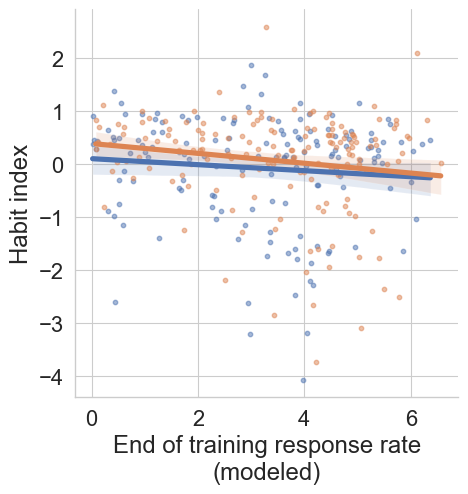

Pearson correlation for end_of_training_pred with habit_level: -0.118, p-value: 0.0198
Spearman correlation for end_of_training_pred with habit_level: -0.106, p-value: 0.0325


In [22]:
sns.set_context("paper", font_scale=1.8, rc={
    "lines.linewidth": 2.5,
    "lines.markersize": 8
})

only_after_devalued_data = main_data_df_w_fitting.copy()
only_after_devalued_data['habit_level'] = -1 * only_after_devalued_data['behav_adaptation_SCORE_NORMED']

pallette = ['#008B8B']

print(only_after_devalued_data.shape)
sns.lmplot(data=only_after_devalued_data, x='end_of_training_pred', y='habit_level', hue='group', order=1,scatter_kws={'s': 10, 'alpha': 0.5}, height=5, aspect=1, legend=False) 
plt.ylabel('Habit index')
plt.xlabel('End of training response rate\n(modeled)')
plt.show()

# Pearson correlation (and Spearman to verify robustness using non-parametric correlation):
pearson_corr, pearson_p = pearsonr(only_after_devalued_data['end_of_training_pred'], only_after_devalued_data['habit_level'], alternative='less')
print(f"Pearson correlation for end_of_training_pred with habit_level: {pearson_corr:.3f}, p-value: {pearson_p:.4f}")
spearman_corr, spearman_p = spearmanr(only_after_devalued_data['end_of_training_pred'], only_after_devalued_data['habit_level'], alternative='less')
print(f"Spearman correlation for end_of_training_pred with habit_level: {spearman_corr:.3f}, p-value: {spearman_p:.4f}")

# ----- First RT -----

## Modeling

In [23]:
IPI_consistency_data_by_trial = trial_level_df.copy()
IPI_consistency_data_by_trial.rename(columns={'outcome': 'stim_condition', 'subID': 'sub'}, inplace=True)
# convert to ms:
IPI_consistency_data_by_trial['first_RT'] *= 1000

In [24]:
var = 'first_RT'
var_of_comparison = 'stim_condition' 
to_smooth = True
smoothing_window = 1
min_period = None

sns.set_context("paper", font_scale=1.6, rc={
    "lines.linewidth": 2.5,
    "lines.markersize": 8
})

# fit the exponential decay to the data:
# -------------------------------------------
# prepare the data:
relevant_trial_data = IPI_consistency_data_by_trial.copy()
if var_of_comparison:
    grouping_factos = ['sub', 'stim_condition']
    stim_condition = var_of_comparison
else:
    grouping_factos = ['sub']
    stim_condition = 'all_stimuli'

relevant_trial_data.loc[:, 'stim_abs_trial'] = relevant_trial_data.groupby(grouping_factos).cumcount()

# remove nans:
relevant_trial_data = relevant_trial_data[relevant_trial_data[var].notna()]

results_df = pd.DataFrame()

# run the fitting procedure:
for sub in relevant_trial_data['sub'].unique():
    # prepare sub data:
    # ------------------------
    data = relevant_trial_data[relevant_trial_data['sub'] == sub]
    data = data.copy()
    data.loc[:, 'smoothed_data'] = data.groupby('stim_condition')[var].transform(lambda x: x.rolling(window=smoothing_window, min_periods=min_period).mean())
    # remove nans:
    data = data[data['smoothed_data'].notna()].reset_index(drop=True)
    # re-create the stim_abs_trial:
    data.loc[:, 'stim_abs_trial'] = data.groupby(grouping_factos).cumcount()
    
    # Average across conditions at each trial
    avg_data = data.groupby('stim_abs_trial')['smoothed_data'].mean().reset_index()

    x_data = avg_data['stim_abs_trial']
    y_data_smoothed = avg_data['smoothed_data']

    # fit the exponential decay:
    # --------------------------
    # Calculate initial guesses from the data:
    y_start = y_data_smoothed.iloc[0]
    y_end = y_data_smoothed.iloc[-1]
    improvement_guess = abs(y_start - y_end)
    asymp_guess = y_end
    p0 = (asymp_guess, improvement_guess, 0.01)

    popt, pcov = curve_fit(exponential_decay, x_data, y_data_smoothed, p0=p0, maxfev=100000, bounds=([0, 0, 0], [35000, 35000, 10000]))
    y_predicted = exponential_decay(x_data, *popt)

    # Calculate the residuals, sum of squares of residuals and the total sum of squares
    residuals = y_data_smoothed - y_predicted
    ss_residuals = np.sum(residuals**2)
    ss_total = np.sum((y_data_smoothed - np.mean(y_data_smoothed))**2)
    # calculate the R squared:
    r_squared = 1 - (ss_residuals / ss_total)

    # relative gain of performance ('improvement') by the final point (according to the model):
    end_of_training_pred = exponential_decay(x_data.max(), *popt)
    relative_improvement_accomplished = 1 - ((end_of_training_pred - popt[0]) / popt[1])

    results_df = pd.concat([results_df, pd.DataFrame({'sub': sub, 'group': data['group'].iloc[0], 'stim_condition': stim_condition, 'asymp_to': popt[0], 'improvement': popt[1], 'alpha': popt[2], 'end_of_training_pred': end_of_training_pred, 'relative_improvement_accomplished': relative_improvement_accomplished, 'r_squared': r_squared}, index=[0])])
    
results_df = results_df.reset_index(drop=True)
print(f'mean R^2: {results_df.r_squared.mean().round(3)}')

mean R^2: 0.125


In [25]:
# add the data to the main data:
# -------------------------------------------
Dependent_vars_copy = IPI_df[['subID', 'behav_adaptation_SCORE_NORMED']].drop_duplicates()
Dependent_vars_copy.rename(columns={'subID': 'sub'}, inplace=True)
main_data_df_w_fitting = pd.merge(Dependent_vars_copy, results_df.drop(columns=['stim_condition']), on=['sub'], how='left')

## stats (and plot)

(306, 10)


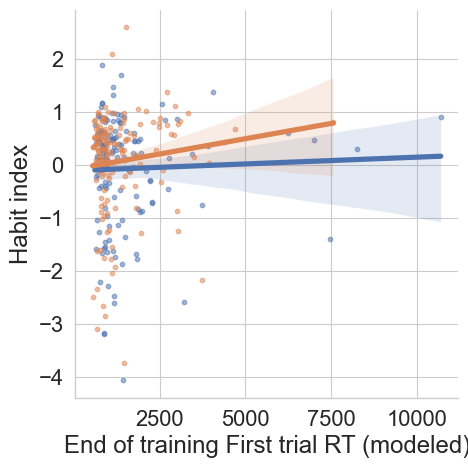

(306, 10)


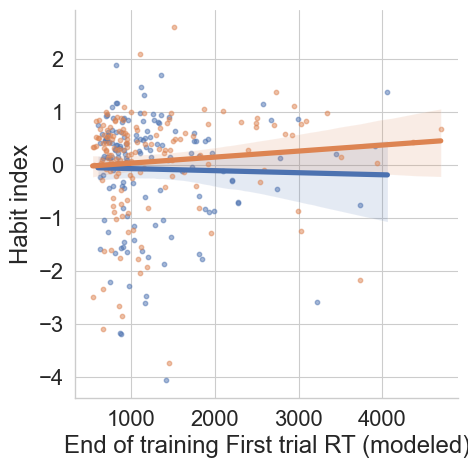

Pearson correlation for end_of_training_pred with habit_level: 0.062, p-value: 0.1414
Spearman correlation for end_of_training_pred with habit_level: 0.029, p-value: 0.3041


In [26]:
sns.set_context("paper", font_scale=1.8, rc={
    "lines.linewidth": 2.5,
    "lines.markersize": 8
})

only_after_devalued_data = main_data_df_w_fitting.copy()
only_after_devalued_data['habit_level'] = -1 * only_after_devalued_data['behav_adaptation_SCORE_NORMED']

pallette = ['#008B8B']

print(only_after_devalued_data.shape)
sns.lmplot(data=only_after_devalued_data, x='end_of_training_pred', y='habit_level', hue='group', order=1,scatter_kws={'s': 10, 'alpha': 0.5}, height=5, aspect=1, legend=False) 
plt.ylabel('Habit index')
plt.xlabel('End of training First trial RT (modeled)')
plt.show()

print(only_after_devalued_data.shape)
sns.lmplot(data=only_after_devalued_data[only_after_devalued_data.end_of_training_pred<5000], x='end_of_training_pred', y='habit_level', hue='group', order=1,scatter_kws={'s': 10, 'alpha': 0.5}, height=5, aspect=1, legend=False) 
plt.ylabel('Habit index')
plt.xlabel('End of training First trial RT (modeled)')
plt.show()

# Pearson correlation (and Spearman to verify robustness using non-parametric correlation):
pearson_corr, pearson_p = pearsonr(only_after_devalued_data['end_of_training_pred'], only_after_devalued_data['habit_level'], alternative='greater')
print(f"Pearson correlation for end_of_training_pred with habit_level: {pearson_corr:.3f}, p-value: {pearson_p:.4f}")
spearman_corr, spearman_p = spearmanr(only_after_devalued_data['end_of_training_pred'], only_after_devalued_data['habit_level'], alternative='greater')
print(f"Spearman correlation for end_of_training_pred with habit_level: {spearman_corr:.3f}, p-value: {spearman_p:.4f}")